In [1]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython.display import display

In [2]:
import torch
from torch.autograd import Variable
import torch.optim as optim
from sklearn.datasets import load_iris


In [3]:
def oneHotIt_tensor(Y, n_classes):
    ones = torch.sparse.torch.eye(n_classes)
    return ones.index_select(0,Y)

def softmax(Z):
    # computes softmax for all samples, normalize among classes (columns)
    # input Z: scores; shape: samples rows x classes columns
    # output S: same shape of input
    EZ = torch.exp(Z)
    S = EZ / torch.sum(EZ,1,keepdim=True) # normaliza nas classes - colunas
    return S

def predict(X,WT):
    Y_oh_hat = softmax(X.mm(WT))
    # escolhe a maior probabilidade entre as classes
    # maxs, indices = torch.max(x, [dim])

    val,Y_hat = torch.max(Y_oh_hat,1) # mantém o resultado como matriz bidimensional
    return val,Y_hat







def getAccuracy(X,WT, Y):
    a,Y_hat = predict(X,WT)
    #print(type(a))
    #print(type(Y_hat))
    
    accuracy = sum(Y_hat == Y)/(float(len(Y)))
    return accuracy

In [4]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
Y = iris.target
print('X.shape:',X.shape)
print('Y.shape:',Y.shape)

X.shape: (150, 2)
Y.shape: (150,)


In [5]:
# Assuming that dataframes df1 and df2 are already defined:
df = pd.DataFrame(X, index=Y, columns=['comprimento sepalas','comprimento petalas'])
df.columns.name = 'classe'
print('Imprimindo primeiros 5 amostras')
display(df.head()) # imprime o começo da tabela
print('Imprimindo 5 últimas amostras')
display(df.tail()) # imprime o final

Imprimindo primeiros 5 amostras


classe,comprimento sepalas,comprimento petalas
0,5.1,1.4
0,4.9,1.4
0,4.7,1.3
0,4.6,1.5
0,5.0,1.4


Imprimindo 5 últimas amostras


classe,comprimento sepalas,comprimento petalas
2,6.7,5.2
2,6.3,5.0
2,6.5,5.2
2,6.2,5.4
2,5.9,5.1


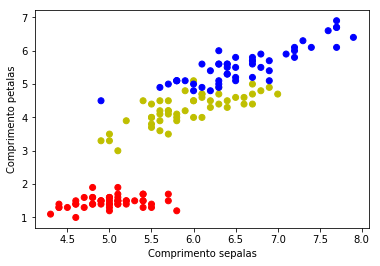

In [6]:
colors = np.array(['r','y','b'])
plt.scatter(X[:, 0], X[:, 1], c=colors[Y])
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

## Visualizando o dataset

Como feito no notebook passado, as amostras são visualizadas com o `scatter`. A cor de cada amostra é selecionada pela sua classe: 0: red, 1: yellow: 2: blue. A cor é indexada pelo vetor `Y` das classes.

In [7]:
# normalização global - não deve ser usada
X_a = X - X.min()
X_a /= X_a.max()

# normalização correta - por coluna
X_c = X - X.min(axis=0,keepdims=True)
X_c /= X_c.max(axis=0,keepdims=True)

## Visualização dados normalizados

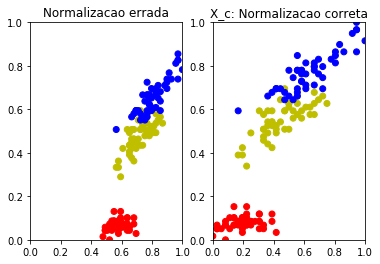

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.set_ylim(0,1)
ax1.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_xlim(0,1)
ax1.scatter(X_a[:, 0], X_a[:, 1], c=colors[Y])
ax2.scatter(X_c[:, 0], X_c[:, 1], c=colors[Y])
ax1.set_title('Normalizacao errada')
ax2.set_title('X_c: Normalizacao correta')

def oneHotIt2(Y,n_classes):
    Y = Y.reshape(-1,1)
    i = np.arange(n_classes).reshape(1,n_classes)
    Y_oh = (Y == i).astype(int)
    return Y_oh

def oneHotIt(Y,n_classes):
    n_samples = Y.size # número de amostras
    i = np.arange(n_samples)
    Y_oh = np.zeros(shape=(n_samples,n_classes))
    Y_oh[i,Y] = 1
    return Y_oh

## Colocando a coluna 0 em X com 1s como o 'bias'

Conforme visto no exercício da Regressão Linear, a equação linear de y em função de x0, x1, x_k tem um fator independente de x, denominado bias. Inserindo-se a coluna 0 de X com 1, é equivalente a definir o w0 como bias.

In [9]:
X_bias = np.hstack([np.ones((150,1)),X_c]) # incluído X com coluna de 1s para gerar bias no W
print('X_bias[:5]=\n',X_bias[:5])

X_bias[:5]=
 [[ 1.          0.22222222  0.06779661]
 [ 1.          0.16666667  0.06779661]
 [ 1.          0.11111111  0.05084746]
 [ 1.          0.08333333  0.08474576]
 [ 1.          0.19444444  0.06779661]]


## Este é o laço principal da Regressão Logística por Softmax

Os pesos são inicializados em zero, sem fator de regularização.
Em cada iteração, a função a ser minimizada é calculada e os pesos são ajustados
pelo técnica de gradiente descendente.

In [10]:
n_amostras = X_bias.shape[0] # number of training examples
n_atributos = X_bias.shape[1] # number of attributes (features, pixels + 1(bias))
n_classes = 3         # number of classes
WT = np.zeros((n_atributos,n_classes)) # n. de linhas é igual a número de atributos (features, pixels)
epochs = 3000
learningRate = 0.01


In [11]:
print('X.shape:',X.shape)
print('Y.shape:',Y.shape)



X.shape: (150, 2)
Y.shape: (150,)


In [12]:
X_train_tensor = torch.from_numpy(X).type(torch.FloatTensor)
ones = torch.ones(X.shape[0],1)
ones = ones.type(torch.FloatTensor)
X_bias = torch.cat((ones, X_train_tensor), 1)
print(X_train_tensor.size())
print(X_bias.size())

torch.Size([150, 2])
torch.Size([150, 3])


In [13]:
Y_train_tensor = torch.from_numpy(Y).type(torch.LongTensor)
Y_tensor = oneHotIt_tensor(Y_train_tensor,3)
print(Y_tensor.size())

torch.Size([150, 3])


In [14]:
WT = torch.zeros((n_atributos,n_classes))

print(WT.size())

torch.Size([3, 3])


In [15]:
losses = []
for i in range(epochs):
    #Z = X_bias.dot(WT)
    Z = X_bias.mm(WT)
    Y_oh_hat = softmax(Z)
    loss = (-1. / n_amostras) * torch.sum(Y_tensor * torch.log(Y_oh_hat))
    Grad = (-1. / n_amostras) * (torch.t(X_bias)).mm(Y_tensor - Y_oh_hat)    

    WT = WT - (learningRate * Grad)
    losses.append(loss)
print('Final loss:',loss)

Final loss: 0.3064621494275828


## Visualizando a minimização da Perda durante o treinamento

É fundamental acompanhar o comportamento da Perda durante o treinamento, pois é difícil prever se os parâmetros do gradiente descendente estão bons.

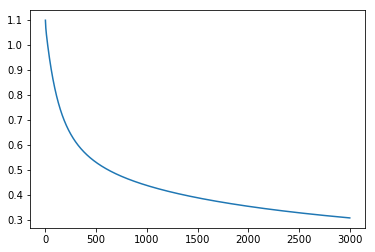

In [16]:
plt.plot(losses)

## Predict

## Colocando a coluna 0 em X com 1s como o 'bias'

Conforme visto no exercício da Regressão Linear, a equação linear de y em função de x0, x1, x_k tem um fator independente de x, denominado bias. Inserindo-se a coluna 0 de X com 1, é equivalente a definir o w0 como bias.

In [17]:
print('Training Accuracy: ', getAccuracy(X_bias,WT,Y_train_tensor), '%')

Training Accuracy:  0.9466666666666667 %


In [18]:
val, y_pred_max = predict(X_bias,WT)
y_pred_max = y_pred_max.numpy()
print(y_pred_max.shape)

(150,)


In [19]:
print('Matriz de confusão (Treino):')
display(pd.crosstab(y_pred_max, Y_train_tensor.numpy()))

Matriz de confusão (Treino):


col_0,0,1,2
row_0,,,
0,50,0,0
1,0,43,1
2,0,7,49
